In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.5


# Interpolation with PyMC3

## A 1D example

To start, we'll do a simple 1D example where we have a model evaluated at control points and we interpolate between them to estimate the model value.

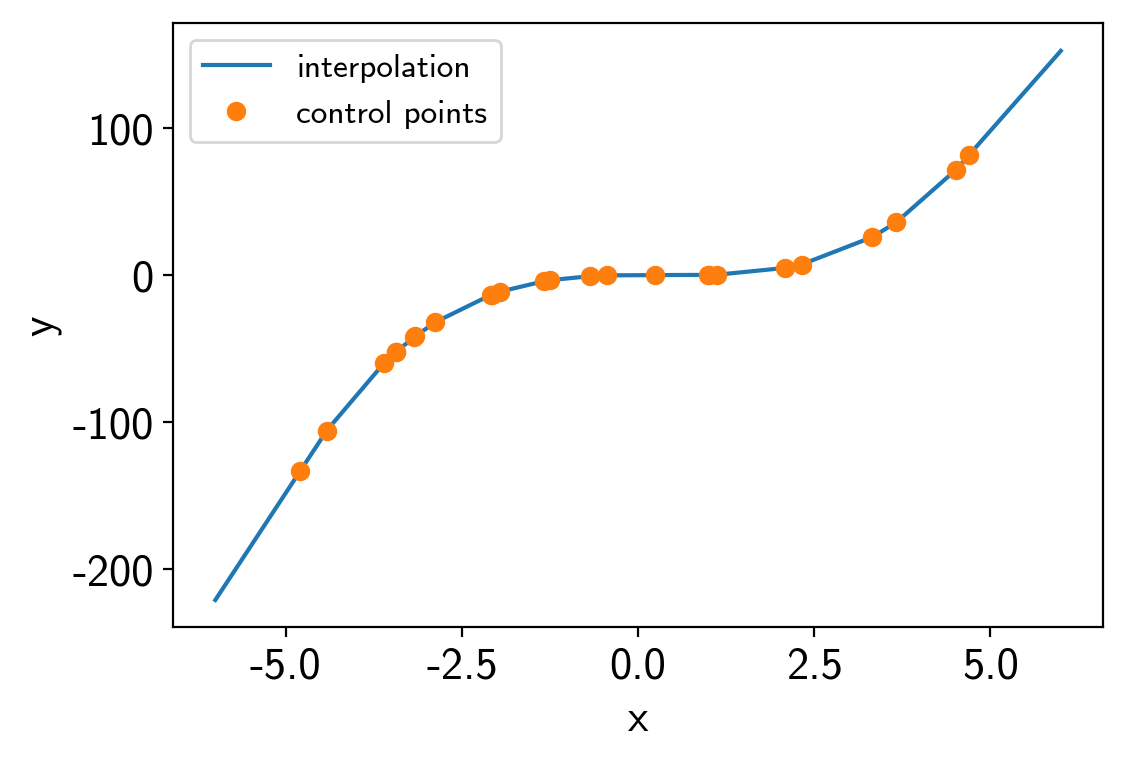

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

np.random.seed(42)
x = np.sort(np.random.uniform(-5, 5, 25))
points = [x]
values = x**3-x**2

interpolator = xo.interp.RegularGridInterpolator(points, values[:, None])

t = np.linspace(-6, 6, 5000)
plt.plot(t, interpolator.evaluate(t[:, None]).eval(), label="interpolation")
plt.plot(x, values, "o", label="control points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=12);

Here's how we build the PyMC3 model:

In [4]:
import pymc3 as pm

truth = 45.0
data_sd = 8.0
data_mu = truth + data_sd * np.random.randn()

with pm.Model() as model:
    
    # The value passed into the interpolator must have the shape
    # (ntest, ndim), but in our case that is (1, 1)
    xval = pm.Uniform("x", lower=-8, upper=8, shape=(1, 1))
    
    # Evaluate the interpolated model and extract the scalar value
    # we want
    mod = pm.Deterministic("y", interpolator.evaluate(xval)[0, 0])
    
    # The usual likelihood
    pm.Normal("obs", mu=mod, sd=data_sd, observed=data_mu)
    
    # Sampling!
    trace = pm.sample(draws=1000, tune=2000, step_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [x]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 627/12000 [00:00<00:01, 6266.84draws/s]

Sampling 4 chains:  11%|█▏        | 1365/12000 [00:00<00:01, 6563.80draws/s]

Sampling 4 chains:  18%|█▊        | 2152/12000 [00:00<00:01, 6907.21draws/s]

Sampling 4 chains:  25%|██▌       | 3034/12000 [00:00<00:01, 7385.69draws/s]

Sampling 4 chains:  32%|███▏      | 3836/12000 [00:00<00:01, 7564.38draws/s]

Sampling 4 chains:  38%|███▊      | 4607/12000 [00:00<00:00, 7604.86draws/s]

Sampling 4 chains:  45%|████▌     | 5423/12000 [00:00<00:00, 7757.60draws/s]

Sampling 4 chains:  52%|█████▏    | 6248/12000 [00:00<00:00, 7897.22draws/s]

Sampling 4 chains:  58%|█████▊    | 7007/12000 [00:00<00:00, 7747.17draws/s]

Sampling 4 chains:  65%|██████▍   | 7761/12000 [00:01<00:00, 7335.98draws/s]

Sampling 4 chains:  71%|███████   | 8485/12000 [00:01<00:00, 7282.54draws/s]

Sampling 4 chains:  78%|███████▊  | 9376/12000 [00:01<00:00, 7704.11draws/s]

Sampling 4 chains:  86%|████████▌ | 10307/12000 [00:01<00:00, 8118.13draws/s]

Sampling 4 chains:  93%|█████████▎| 11126/12000 [00:01<00:00, 8085.02draws/s]

Sampling 4 chains: 100%|█████████▉| 11940/12000 [00:01<00:00, 5391.67draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [00:01<00:00, 6938.86draws/s]

And here are the results:

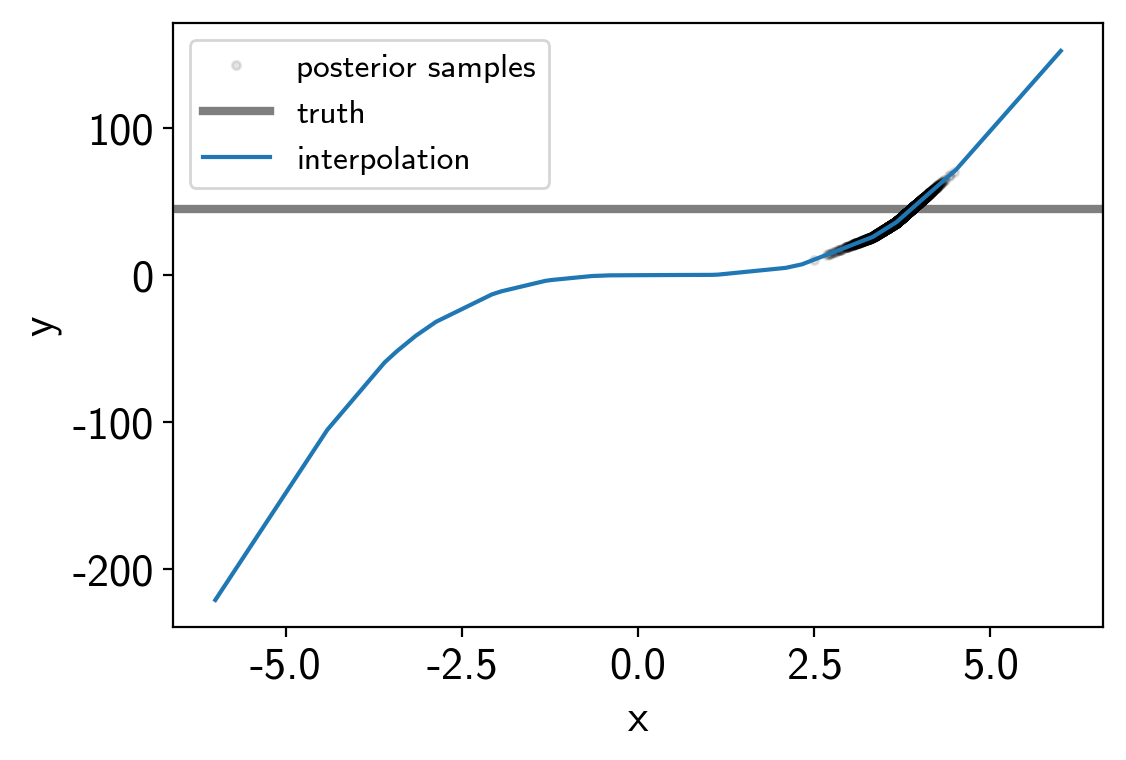

In [5]:
t = np.linspace(-6, 6, 5000)
plt.plot(trace["x"][:, 0, 0], trace["y"], ".k", alpha=0.1, label="posterior samples")
plt.axhline(truth, color="k", lw=3, alpha=0.5, label="truth")
plt.plot(t, interpolator.evaluate(t[:, None]).eval(), label="interpolation")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=12);

## A 2D example

In this case, we'll interpolate a 2D function. This one is a hard one because the posterior is a ring, but it demonstrates the principle.

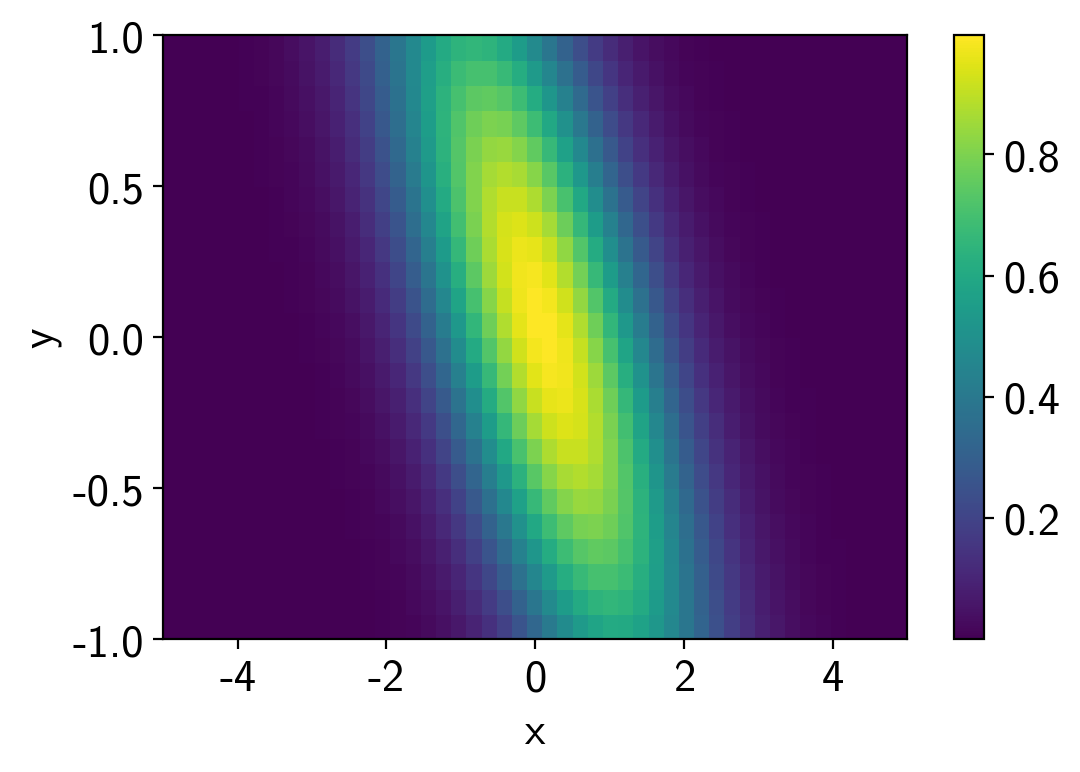

In [6]:
points = [
    np.linspace(-5, 5, 50),
    np.linspace(-1, 1, 25),
]
values = np.exp(-0.5*(points[0]**2)[:, None] - 0.5*(points[1]**2 / 0.5)[None, :] - points[0][:, None]*points[1][None, :])

interpolator = xo.interp.RegularGridInterpolator(points, values[:, :, None], nout=1)

plt.pcolor(points[0], points[1], values.T)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y");

Set things up and sample.

In [7]:
import theano.tensor as tt

data_mu = 0.6
data_sd = 0.1

with pm.Model() as model:
    
    xval = pm.Uniform("x", lower=-5, upper=5, shape=(1,))
    yval = pm.Uniform("y", lower=-1, upper=1, shape=(1,))
    xtest = tt.stack([xval, yval], axis=-1)
    
    mod = interpolator.evaluate(xtest)
    
    # The usual likelihood
    pm.Normal("obs", mu=mod, sd=data_sd, observed=data_mu)
    
    # Sampling!
    trace = pm.sample(draws=4000, tune=4000, step_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [y, x]


Sampling 4 chains:   0%|          | 0/32000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 109/32000 [00:00<00:29, 1085.70draws/s]

Sampling 4 chains:   1%|          | 310/32000 [00:00<00:25, 1259.08draws/s]

Sampling 4 chains:   2%|▏         | 570/32000 [00:00<00:21, 1488.55draws/s]

Sampling 4 chains:   3%|▎         | 839/32000 [00:00<00:18, 1718.70draws/s]

Sampling 4 chains:   4%|▎         | 1136/32000 [00:00<00:15, 1965.84draws/s]

Sampling 4 chains:   5%|▍         | 1460/32000 [00:00<00:13, 2226.19draws/s]

Sampling 4 chains:   6%|▌         | 1813/32000 [00:00<00:12, 2502.63draws/s]

Sampling 4 chains:   7%|▋         | 2116/32000 [00:00<00:11, 2639.94draws/s]

Sampling 4 chains:   8%|▊         | 2435/32000 [00:00<00:10, 2782.76draws/s]

Sampling 4 chains:   9%|▊         | 2762/32000 [00:01<00:10, 2912.52draws/s]

Sampling 4 chains:  10%|▉         | 3067/32000 [00:01<00:10, 2861.76draws/s]

Sampling 4 chains:  11%|█         | 3412/32000 [00:01<00:09, 3015.51draws/s]

Sampling 4 chains:  12%|█▏        | 3723/32000 [00:01<00:09, 3025.25draws/s]

Sampling 4 chains:  13%|█▎        | 4057/32000 [00:01<00:08, 3111.68draws/s]

Sampling 4 chains:  14%|█▎        | 4375/32000 [00:01<00:08, 3130.91draws/s]

Sampling 4 chains:  15%|█▍        | 4692/32000 [00:01<00:08, 3078.40draws/s]

Sampling 4 chains:  16%|█▌        | 5003/32000 [00:01<00:08, 3077.99draws/s]

Sampling 4 chains:  17%|█▋        | 5313/32000 [00:01<00:08, 2988.14draws/s]

Sampling 4 chains:  18%|█▊        | 5638/32000 [00:01<00:08, 3060.42draws/s]

Sampling 4 chains:  19%|█▊        | 5984/32000 [00:02<00:08, 3169.78draws/s]

Sampling 4 chains:  20%|█▉        | 6304/32000 [00:02<00:08, 3026.37draws/s]

Sampling 4 chains:  21%|██        | 6662/32000 [00:02<00:07, 3172.71draws/s]

Sampling 4 chains:  22%|██▏       | 6984/32000 [00:02<00:08, 3114.43draws/s]

Sampling 4 chains:  23%|██▎       | 7311/32000 [00:02<00:07, 3157.28draws/s]

Sampling 4 chains:  24%|██▍       | 7648/32000 [00:02<00:07, 3212.80draws/s]

Sampling 4 chains:  25%|██▍       | 7972/32000 [00:02<00:07, 3169.90draws/s]

Sampling 4 chains:  26%|██▌       | 8291/32000 [00:02<00:07, 3102.52draws/s]

Sampling 4 chains:  27%|██▋       | 8603/32000 [00:02<00:07, 3089.40draws/s]

Sampling 4 chains:  28%|██▊       | 8913/32000 [00:02<00:07, 2963.19draws/s]

Sampling 4 chains:  29%|██▉       | 9248/32000 [00:03<00:07, 3067.14draws/s]

Sampling 4 chains:  30%|██▉       | 9557/32000 [00:03<00:07, 3044.68draws/s]

Sampling 4 chains:  31%|███       | 9864/32000 [00:03<00:07, 3031.90draws/s]

Sampling 4 chains:  32%|███▏      | 10169/32000 [00:03<00:07, 2956.65draws/s]

Sampling 4 chains:  33%|███▎      | 10509/32000 [00:03<00:06, 3075.01draws/s]

Sampling 4 chains:  34%|███▍      | 10819/32000 [00:03<00:06, 3028.21draws/s]

Sampling 4 chains:  35%|███▍      | 11148/32000 [00:03<00:06, 3101.23draws/s]

Sampling 4 chains:  36%|███▌      | 11460/32000 [00:03<00:06, 3092.48draws/s]

Sampling 4 chains:  37%|███▋      | 11771/32000 [00:03<00:06, 3035.20draws/s]

Sampling 4 chains:  38%|███▊      | 12080/32000 [00:04<00:06, 3048.29draws/s]

Sampling 4 chains:  39%|███▉      | 12421/32000 [00:04<00:06, 3143.53draws/s]

Sampling 4 chains:  40%|███▉      | 12737/32000 [00:04<00:06, 3128.35draws/s]

Sampling 4 chains:  41%|████      | 13051/32000 [00:04<00:06, 3115.35draws/s]

Sampling 4 chains:  42%|████▏     | 13364/32000 [00:04<00:06, 3040.84draws/s]

Sampling 4 chains:  43%|████▎     | 13689/32000 [00:04<00:05, 3098.81draws/s]

Sampling 4 chains:  44%|████▍     | 14015/32000 [00:04<00:05, 3144.50draws/s]

Sampling 4 chains:  45%|████▍     | 14331/32000 [00:04<00:05, 3082.86draws/s]

Sampling 4 chains:  46%|████▌     | 14641/32000 [00:04<00:05, 3000.86draws/s]

Sampling 4 chains:  47%|████▋     | 14943/32000 [00:04<00:05, 2919.88draws/s]

Sampling 4 chains:  48%|████▊     | 15237/32000 [00:05<00:05, 2914.16draws/s]

Sampling 4 chains:  49%|████▊     | 15530/32000 [00:05<00:05, 2915.39draws/s]

Sampling 4 chains:  49%|████▉     | 15835/32000 [00:05<00:05, 2952.81draws/s]

Sampling 4 chains:  50%|█████     | 16131/32000 [00:05<00:05, 2897.76draws/s]

Sampling 4 chains:  51%|█████▏    | 16422/32000 [00:05<00:05, 2845.73draws/s]

Sampling 4 chains:  52%|█████▏    | 16720/32000 [00:05<00:05, 2883.87draws/s]

Sampling 4 chains:  53%|█████▎    | 17089/32000 [00:05<00:04, 3084.33draws/s]

Sampling 4 chains:  55%|█████▍    | 17470/32000 [00:05<00:04, 3269.15draws/s]

Sampling 4 chains:  56%|█████▌    | 17803/32000 [00:05<00:04, 3274.08draws/s]

Sampling 4 chains:  57%|█████▋    | 18135/32000 [00:05<00:04, 3131.45draws/s]

Sampling 4 chains:  58%|█████▊    | 18483/32000 [00:06<00:04, 3222.87draws/s]

Sampling 4 chains:  59%|█████▉    | 18809/32000 [00:06<00:04, 3106.89draws/s]

Sampling 4 chains:  60%|█████▉    | 19186/32000 [00:06<00:03, 3279.58draws/s]

Sampling 4 chains:  61%|██████    | 19519/32000 [00:06<00:03, 3257.67draws/s]

Sampling 4 chains:  62%|██████▏   | 19849/32000 [00:06<00:03, 3220.23draws/s]

Sampling 4 chains:  63%|██████▎   | 20209/32000 [00:06<00:03, 3323.61draws/s]

Sampling 4 chains:  64%|██████▍   | 20544/32000 [00:06<00:03, 3198.24draws/s]

Sampling 4 chains:  65%|██████▌   | 20909/32000 [00:06<00:03, 3320.76draws/s]

Sampling 4 chains:  66%|██████▋   | 21245/32000 [00:06<00:03, 3291.13draws/s]

Sampling 4 chains:  67%|██████▋   | 21577/32000 [00:07<00:03, 3239.88draws/s]

Sampling 4 chains:  68%|██████▊   | 21917/32000 [00:07<00:03, 3284.29draws/s]

Sampling 4 chains:  70%|██████▉   | 22250/32000 [00:07<00:02, 3297.63draws/s]

Sampling 4 chains:  71%|███████   | 22581/32000 [00:07<00:02, 3226.42draws/s]

Sampling 4 chains:  72%|███████▏  | 22945/32000 [00:07<00:02, 3338.82draws/s]

Sampling 4 chains:  73%|███████▎  | 23281/32000 [00:07<00:02, 3184.63draws/s]

Sampling 4 chains:  74%|███████▍  | 23635/32000 [00:07<00:02, 3283.00draws/s]

Sampling 4 chains:  75%|███████▍  | 23966/32000 [00:07<00:02, 3259.39draws/s]

Sampling 4 chains:  76%|███████▌  | 24294/32000 [00:07<00:02, 3118.60draws/s]

Sampling 4 chains:  77%|███████▋  | 24626/32000 [00:07<00:02, 3173.48draws/s]

Sampling 4 chains:  78%|███████▊  | 24946/32000 [00:08<00:02, 3124.86draws/s]

Sampling 4 chains:  79%|███████▉  | 25292/32000 [00:08<00:02, 3217.92draws/s]

Sampling 4 chains:  80%|████████  | 25616/32000 [00:08<00:02, 3100.73draws/s]

Sampling 4 chains:  81%|████████  | 25938/32000 [00:08<00:01, 3130.98draws/s]

Sampling 4 chains:  82%|████████▏ | 26253/32000 [00:08<00:01, 3012.22draws/s]

Sampling 4 chains:  83%|████████▎ | 26595/32000 [00:08<00:01, 3122.96draws/s]

Sampling 4 chains:  84%|████████▍ | 26910/32000 [00:08<00:01, 3089.67draws/s]

Sampling 4 chains:  85%|████████▌ | 27267/32000 [00:08<00:01, 3217.06draws/s]

Sampling 4 chains:  86%|████████▌ | 27592/32000 [00:08<00:01, 3152.11draws/s]

Sampling 4 chains:  87%|████████▋ | 27910/32000 [00:09<00:01, 3051.89draws/s]

Sampling 4 chains:  88%|████████▊ | 28273/32000 [00:09<00:01, 3203.74draws/s]

Sampling 4 chains:  89%|████████▉ | 28620/32000 [00:09<00:01, 3277.57draws/s]

Sampling 4 chains:  90%|█████████ | 28951/32000 [00:09<00:00, 3259.50draws/s]

Sampling 4 chains:  91%|█████████▏| 29279/32000 [00:09<00:00, 3102.89draws/s]

Sampling 4 chains:  93%|█████████▎| 29626/32000 [00:09<00:00, 3203.17draws/s]

Sampling 4 chains:  94%|█████████▎| 29950/32000 [00:09<00:00, 3166.13draws/s]

Sampling 4 chains:  95%|█████████▍| 30269/32000 [00:09<00:00, 2882.56draws/s]

Sampling 4 chains:  96%|█████████▌| 30564/32000 [00:09<00:00, 2641.85draws/s]

Sampling 4 chains:  96%|█████████▋| 30862/32000 [00:10<00:00, 2732.86draws/s]

Sampling 4 chains:  97%|█████████▋| 31142/32000 [00:10<00:00, 2597.07draws/s]

Sampling 4 chains:  98%|█████████▊| 31408/32000 [00:10<00:00, 2450.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31659/32000 [00:10<00:00, 2423.91draws/s]

Sampling 4 chains: 100%|█████████▉| 31906/32000 [00:10<00:00, 1690.96draws/s]

Sampling 4 chains: 100%|██████████| 32000/32000 [00:10<00:00, 2961.90draws/s]

The number of effective samples is smaller than 10% for some parameters.


And here are the results:

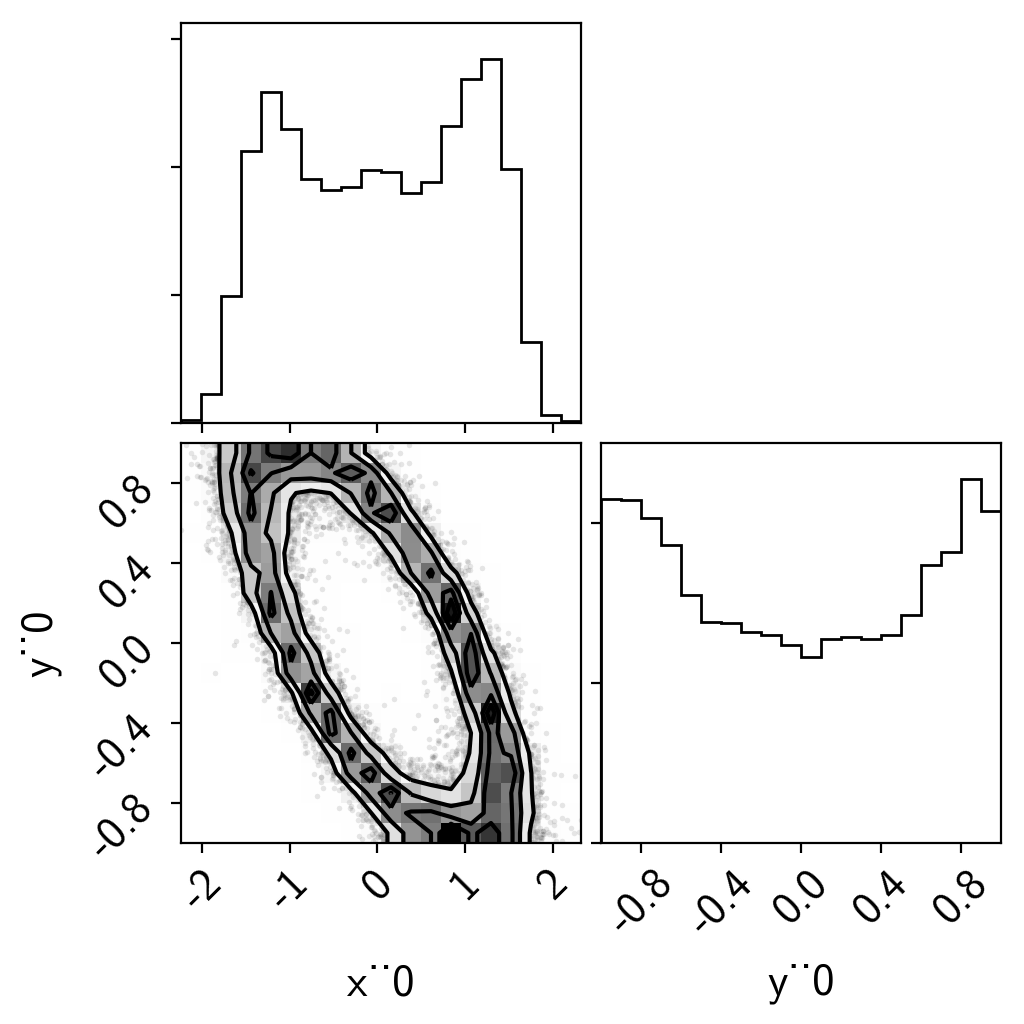

In [8]:
import corner
samples = pm.trace_to_dataframe(trace)
corner.corner(samples);